In [1]:
import requests
import pandas as pd

from datetime import date

In [8]:
def obtener_cae_mensual(cae: str):
    """
    Funcion auxiliar para obtener el cae "mensual" en funcion 
    del valor anualizado
    """
    cae = float(str(cae).replace(',', '.'))
    return (1+cae/100)**(1/12)-1


def calcular_pie(precio_compra: int, porcentaje_pie: str):
    """
    Funcion auxiliar que calcula el pie a colocar
    para comprar el departamento.
    """
    porcentaje_pie = float(str(porcentaje_pie).replace(',', '.'))
    return precio_compra*(porcentaje_pie/100)


def calcular_dividendo(precio_compra: int, porcentaje_pie: str, cae: str, plazo_anual: int):
    """
    Funcion que aproxima el valor del dividendo en funcion del CAE anual
    y el monto solicitado como prestamo hipotecario segun plazo en años
    """
    porcentaje_pie = float(str(porcentaje_pie).replace(',', '.'))
    cae_mensual = obtener_cae_mensual(cae)

    prestamo = precio_compra*(1-porcentaje_pie/100)
    factor = 1-1/((1+cae_mensual)**(plazo_anual*12))

    return prestamo*cae_mensual/factor


def obtener_uf_actualizada():
    """
    Funcion que retorna el valor actual de la uf/clp
    """
    hoy = date.today()
    url = f"https://mindicador.cl/api/uf/{str(hoy.day).zfill(2)}-{str(hoy.month).zfill(2)}-{hoy.year}"
    
    return requests.get(url).json()['serie'][0]['valor']


def obtener_cap_rate(arriendo: float, precio_compra: int):
    """
    Funcion que calcula valor del cap rate para el proyecto entregado
    en funcion del arriendo mercado detactado.
    """
    return arriendo*12/precio_compra


def obtener_arriendo():
    """
    TODO:
    Funcion que obtiene el vaor del arriendo segun el approach de la IA
    """
    return 280000/37312


def obtener_gap_arriendo_dividendo(arriendo: float, dividendo: float,
                                    moneda_arriendo: str, valor_uf: float):
    """
    Funcion que obtiene el gap producido por arrendar y el dividendo
    """
    arriendo = arriendo/valor_uf if moneda_arriendo == 'CLP' else arriendo
    return arriendo-dividendo


def obtener_rentabilidad_flujo(plazo_venta: int, gap_anual: float, capital: float):
    """
    Funcion que calcula la rentabilidad de los flujos sobre el
    valor del activo, todo en valor UF.
    """
    flujos_beneficios = plazo_venta*gap_anual
    return flujos_beneficios/capital


def obtener_rentabilidad_plusvalia(plazo_venta: int, plusvalia_hist: str, precio_compra: int, capital:float):
    """
    Funcion que calcula la rentabilidad de la plusvalia proyectada.
    Asume que la plusvalia crece en funcion del ratio historico.
    """
    plusvalia_hist = float(str(plusvalia_hist).replace(',', '.'))
    return precio_compra*((1+plusvalia_hist/100)**(plazo_venta)-1)/capital


def calcular_tabla_amortizacion(precio_compra: int, porcentaje_pie: str, 
                                cae: str, plazo_anual: int):
    """
    Funcion que calcular la tabla de amortizacion del
    credito hipotecario.
    """
    porcentaje_pie = float(str(porcentaje_pie).replace(',', '.'))
    dividendo = calcular_dividendo(precio_compra, porcentaje_pie, cae, plazo_anual)
    cae_mensual = obtener_cae_mensual(cae)
    prestamo = precio_compra*(1-porcentaje_pie/100)
    tabla_amortizacion = {
        0: {
            'cuota': '',
            'interes': '',
            'amortizacion': '',
            'saldo': prestamo
            }
        }
    for t in range(1, plazo_anual*12+1):
        interes = tabla_amortizacion[t-1]['saldo']*cae_mensual
        amortizacion = dividendo - interes
        saldo = tabla_amortizacion[t-1]['saldo'] - amortizacion
        tabla_amortizacion[t] = {
            'cuota': dividendo,
            'interes': interes,
            'amortizacion': amortizacion,
            'saldo': saldo
        }
    return tabla_amortizacion


def obtener_rentabilidad_amortizacion(precio_compra: int, porcentaje_pie: str, plazo_venta: int, tabla_amortizacion: dict, capital: float):
    """
    Funcion que calcula la rentabilidad de la amortizacion del credito
    hipotecario solicitado por el inversionista.
    """
    porcentaje_pie = float(str(porcentaje_pie).replace(',', '.'))
    prestamo = precio_compra*(1-porcentaje_pie/100)
    saldo_capital = tabla_amortizacion[plazo_venta*12]['saldo']
    return (prestamo - saldo_capital)/capital


def obtener_utilidades_no_venta(capital: float, rent_flujos: float, rent_plusvalia: float, rent_amortizacion: float):
    """
    Funcion para calcular las utilidades de la inversion luego
    de un plazo especifico, sin vender el depto.
    """
    utilidad_flujos = capital*rent_flujos
    utilidad_amortizacion = capital*rent_amortizacion
    utilidad_plusvalia = capital*rent_plusvalia
   
    return utilidad_flujos+utilidad_amortizacion+utilidad_plusvalia


def obtener_utilidades_venta(precio_compra: int, capital: float, rent_flujos: float, rent_plusvalia: float, rent_amortizacion: float):
    """
    Funcion para calcular las utilidades de la inversion luego
    de un plazo especifico, sin vender el depto.
    """
    utilidad_flujos = capital*rent_flujos
    utilidad_amortizacion = capital*rent_amortizacion
    utilidad_plusvalia = capital*rent_plusvalia
    corretaje = 0.04*(precio_compra+utilidad_plusvalia)

    return utilidad_flujos+utilidad_amortizacion+utilidad_plusvalia-corretaje


def obtener_roi(utilidad: int, capital: float):
    """
    Funcion para calcular la rentabilidad de la inversion segun las 
    utilidades en plazo especifico.
    """    
   
    return utilidad/capital


def anualizar_tasa(tasa: float, plazo: int):
    """
    Funcion que anualizad tasas de interes para entender efecto
    de interes compuesto anual.
    """
    signo = 1
    if tasa <= 0:
        signo = -1

    return signo*((1+abs(tasa))**(1/plazo)-1)

8.05683900415871 7.504288164665523 -0.552550839493188
Año 1
Rent. Flujo: -1.63%
Rent. Plusvalia: 16.35%
Rent. Amotizacion: 5.62%
ROI sin venta: 20.34%
ROI con venta: 1.00%

Año 2
Rent. Flujo: -1.62%
Rent. Plusvalia: 15.44%
Rent. Amotizacion: 5.61%
ROI sin venta: 18.97%
ROI con venta: 10.24%

Año 3
Rent. Flujo: -1.60%
Rent. Plusvalia: 14.67%
Rent. Amotizacion: 5.59%
ROI sin venta: 17.84%
ROI con venta: 12.64%

Año 4
Rent. Flujo: -1.59%
Rent. Plusvalia: 14.00%
Rent. Amotizacion: 5.58%
ROI sin venta: 16.88%
ROI con venta: 13.37%

Año 5
Rent. Flujo: -1.58%
Rent. Plusvalia: 13.42%
Rent. Amotizacion: 5.56%
ROI sin venta: 16.06%
ROI con venta: 13.51%

Año 6
Rent. Flujo: -1.57%
Rent. Plusvalia: 12.90%
Rent. Amotizacion: 5.55%
ROI sin venta: 15.35%
ROI con venta: 13.39%

Año 7
Rent. Flujo: -1.56%
Rent. Plusvalia: 12.44%
Rent. Amotizacion: 5.53%
ROI sin venta: 14.72%
ROI con venta: 13.17%

Año 8
Rent. Flujo: -1.54%
Rent. Plusvalia: 12.02%
Rent. Amotizacion: 5.52%
ROI sin venta: 14.17%
ROI con ve

<AxesSubplot: title={'center': 'Rentabilidad, con pie 20%'}, xlabel='Año'>

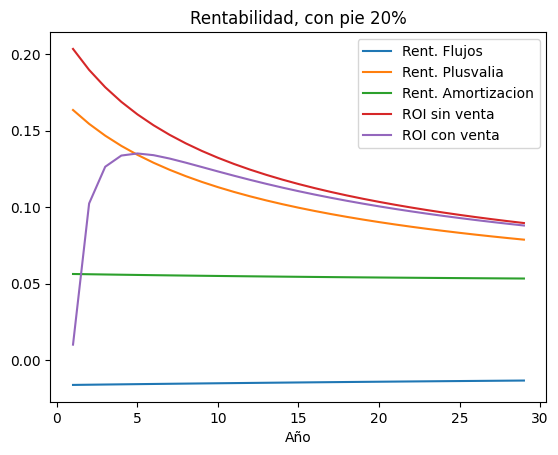

In [17]:
# Valores ingresado por el usuario
precio_compra = 1900
porcentaje_pie = '20'
cae = '5'
plazo_credito = 30
dividendo = None
uf = 37312  # obtener_uf_actualizada()
ggoo = 1e6/uf
plusvalia_hist = '3.5'

# 0º calcular el pie
pie = calcular_pie(precio_compra, porcentaje_pie)
# 1º calcular el dividendo si no fue entregado
dividendo = calcular_dividendo(precio_compra, porcentaje_pie, cae, plazo_credito)
# 2º definir el capital inicial del inversionista
capital = pie + ggoo
# 3º calcaular la tabla de amortizacion 
tabla_amortizacion = calcular_tabla_amortizacion(precio_compra, porcentaje_pie, cae, plazo_credito)
# 4º calcular arriendo del proyecto
arriendo_mercado_ia = obtener_arriendo()
# 5º calcular el caprate del proyecto
cap_rate = obtener_cap_rate(arriendo_mercado_ia, precio_compra)
# 6º calcular el gap de arriendo y dividendo
gap_mensual = obtener_gap_arriendo_dividendo(arriendo_mercado_ia, dividendo, 'UF', uf)
print(dividendo, arriendo_mercado_ia, gap_mensual)
#### Esta parte es para construir el grafico de venta
datos = []
for i in range(1, plazo_credito):
    plazo_venta = i
    # 7º calcular rentabilidad por flujos
    rentabilidad_flujos = obtener_rentabilidad_flujo(plazo_venta, gap_mensual*12, capital)
    # 8º calcular rentabilidad por plusvalia
    rentabilidad_plusvalia = obtener_rentabilidad_plusvalia(plazo_venta, plusvalia_hist, precio_compra, capital)
    # 9º calcular rentabilidad por amortizacion
    rentabilidad_amortizacion = obtener_rentabilidad_amortizacion(precio_compra, porcentaje_pie, plazo_venta, tabla_amortizacion, capital)
    # 10º calcular utilidad sin venta
    utilidad_no_venta = obtener_utilidades_no_venta(capital, rentabilidad_flujos, rentabilidad_plusvalia, rentabilidad_amortizacion)
    # 11º calcular utilidad con venta
    utilidad_venta = obtener_utilidades_venta(precio_compra, capital, rentabilidad_flujos, rentabilidad_plusvalia, rentabilidad_amortizacion)
    # 11º calcular ROI sin venta
    roi_sin_venta = obtener_roi(utilidad_no_venta, capital)
    # 12º calcular ROI con venta
    roi_con_venta = obtener_roi(utilidad_venta, capital)
    # 12º anualizar las rentabilidades
    if True:
        rentabilidad_flujos = anualizar_tasa(rentabilidad_flujos, plazo_venta)
        rentabilidad_plusvalia = anualizar_tasa(rentabilidad_plusvalia, plazo_venta)
        rentabilidad_amortizacion = anualizar_tasa(rentabilidad_amortizacion, plazo_venta)
        roi_sin_venta = anualizar_tasa(roi_sin_venta, plazo_venta)
        roi_con_venta = anualizar_tasa(roi_con_venta, plazo_venta)

    if True:
        print("Año", i)
        print(f"Rent. Flujo: {rentabilidad_flujos*100:.2f}%")
        print(f"Rent. Plusvalia: {rentabilidad_plusvalia*100:.2f}%")
        print(f"Rent. Amotizacion: {rentabilidad_amortizacion*100:.2f}%")
        print(f"ROI sin venta: {roi_sin_venta*100:.2f}%")
        print(f"ROI con venta: {roi_con_venta*100:.2f}%")
        print()

    # guardar valores historicos para graficar
    datos.append([plazo_venta, rentabilidad_flujos, rentabilidad_plusvalia, rentabilidad_amortizacion, roi_sin_venta, roi_con_venta])

# graficar valores
pd.DataFrame(
    datos, 
    columns=[
        'Año',
        'Rent. Flujos',
        'Rent. Plusvalia', 
        'Rent. Amortizacion',
        'ROI sin venta',
        'ROI con venta']
    ).plot(
        x='Año',
        y=[
            'Rent. Flujos',
            'Rent. Plusvalia',
            'Rent. Amortizacion',
            'ROI sin venta',
            'ROI con venta'],
        title=f'Rentabilidad, con pie {porcentaje_pie}%'
    )